# In this notebook a Tracks Class from filters.py is used to calculate different features of tracks and assist in applying filters accordingly 

In [1]:
import pandas as pd 
import numpy as np 
import sys
sys.path.append('../src/')
from filters import Track, create_tracks_from_dataframe, drop_short_tracks
from filters import drop_early_peak_tracks, drop_last_frame_peak_tracks, drop_tracks_below_intensity
from filters import plot_z_sum, allocate_membrane_regions

In [2]:
track_df = pd.read_pickle('/Users/apple/Desktop/Akamatsu_Lab/Lap_track/Final/data/track_df_updated.pkl')

In [3]:
track_df.head()

,frame,index,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame_y,...,c3_mean_amp,c2_peak_mean,c2_voxel_sum,c3_voxel_sum,c1_amp,c1_peak,c1_peak_x,c1_peak_y,c1_peak_z,c1_voxel_sum
0,0,0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0,...,163.682353,125.500000,11295,13913,175.329412,231.0,10.0,14.0,2.0,12090
1,0,1,191.000000,36.0,88.0,1.0,2.0,1.0,2.0,0,...,138.233333,114.826667,20068,19928,157.133333,189.0,38.0,87.0,3.0,32795
2,0,2,231.007679,40.0,141.0,1.0,2.0,2.0,2.0,0,...,153.940000,122.853333,15316,22805,154.560000,198.0,40.0,140.0,3.0,31784
3,0,3,185.152538,40.0,58.0,1.0,2.0,1.0,3.0,0,...,141.280000,118.016667,14557,20358,152.960000,196.0,42.0,59.0,3.0,31530
4,0,4,202.000000,46.0,73.0,1.0,2.0,2.0,3.0,0,...,147.768000,115.502857,23194,21963,160.240000,219.0,48.0,72.0,4.0,37523


In [4]:
tracks = create_tracks_from_dataframe(df = track_df, intensities_col_name = ['amplitude', 'c2_peak', 'c1_peak'], 
track_id_col_name = 'track_id', frame_col_name = 'frame', coords = ['mu_x', 'mu_y', 'mu_z'])

In [5]:
# Create DataFrame from Track instances
tracks_data = {
    'track_id': [track.track_id.values[0] for track in tracks],
    'track_length': [track.track_length for track in tracks],
    'track_start': [track.track_start for track in tracks],
    'track_end': [track.track_end for track in tracks],
    'c3_peak': [track.peak_intensities[0] for track in tracks],
    'c2_peak': [track.peak_intensities[1] for track in tracks],
    'c1_peak': [track.peak_intensities[2] for track in tracks],
    'c3_peak_frame': [track.peak_intensity_frames[0] for track in tracks],
    'c2_peak_frame': [track.peak_intensity_frames[1] for track in tracks],
    'c1_peak_frame': [track.peak_intensity_frames[2] for track in tracks],
    'mean_displacement': [track.mean_displacement_track for track in tracks],
    'mean_z': [track.mean_z_value for track in tracks],
    'mean_z_displacement': [track.mean_z_displacement for track in tracks]
}

tracks_df = pd.DataFrame(tracks_data)

In [6]:
tracks_df.head()

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement
0,0,1,0,0,206.593249,152.0,231.0,0,0,0,NaN,0.0,NaN
1,1,1,0,0,191.000000,143.0,189.0,0,0,0,NaN,1.0,NaN
2,2,1,0,0,231.007679,142.0,198.0,0,0,0,NaN,1.0,NaN
3,3,1,0,0,185.152538,142.0,196.0,0,0,0,NaN,1.0,NaN
4,4,2,0,1,202.000000,141.0,219.0,0,0,0,1.0,1.0,0.0


In [7]:
tracks_df[tracks_df['track_id']==541]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement
541,541,22,1,22,321.0,211.0,301.0,9,9,14,1.712512,53.136364,1.0


In [8]:
tracks_df.shape

(18923, 13)

# DROPPING SHORT TRACKS 

In [9]:
#dropping tracks of length 3 and below
length_filtered_tracks_df = drop_short_tracks(df = tracks_df, threshold = 3)

In [10]:
length_filtered_tracks_df.shape

(5056, 13)

## Determining Valid Channel 3 tracks 

### Dropping tracks with Clathrin (Channel 3 peak in the last frame)

In [11]:
valid_c3_tracks = drop_last_frame_peak_tracks(df = length_filtered_tracks_df, intensity_col = 'c3_peak_frame')

In [12]:
valid_c3_tracks.shape

(4123, 13)

### Dropping tracks with Clathrin (Channel 3) which have their peaks in the first three frames 

In [13]:
valid_c3_tracks = drop_early_peak_tracks(df = valid_c3_tracks, intensity_peak_frame = 'c3_peak_frame', 
                                      cutoff = 3)

In [14]:
valid_c3_tracks.shape

(842, 13)

**valid_c3_tracks will serve as baseline clathrin positive and valid tracks**

# Filtering for Channel 2 (Dynamin)

## Filter 1 
### Identifying Dynamin Positive Tracks 

In [15]:
dnm2_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = 170, 
                                          intensity_peak_frame = 'c2_peak' )

In [16]:
dnm2_positive_tracks.shape

(569, 13)

## Filter 2
### Filter tracks based on channel 2 peak if occurs within 3 frames of starting of a track 

In [17]:
dnm2_positive_tracks = drop_early_peak_tracks(df = dnm2_positive_tracks, intensity_peak_frame = 'c2_peak_frame', 
                                      cutoff = 3)

In [18]:
dnm2_positive_tracks.shape

(383, 13)

## Filter 3
### Filter tracks based on channel 2 peaks occuring in the last frame 

In [19]:
dnm2_positive_tracks = drop_last_frame_peak_tracks(df = dnm2_positive_tracks, intensity_col = 'c2_peak_frame')

In [20]:
dnm2_positive_tracks.shape

(312, 13)

**dnm2_positive_tracks will serve as the baseline for dynamin positive tracks**

# Identifying Channel 1 (Actin) positive tracks 

## Filter 1 
### Identifying Actin Positive Tracks 

In [21]:
actin_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = 240, 
                                          intensity_peak_frame = 'c1_peak' )

In [22]:
actin_positive_tracks.shape

(712, 13)

## Filter 2 
### Filter tracks based on channel 1 peaks if occurs within the first 3 frames 

In [23]:
actin_positive_tracks = drop_early_peak_tracks(df = actin_positive_tracks, intensity_peak_frame = 'c1_peak_frame', 
                                      cutoff = 3)

In [24]:
actin_positive_tracks.shape

(450, 13)

## Filter 3
### Filter tracks based on channel 1 peaks occuring in the last frame 

In [25]:
actin_positive_tracks = drop_last_frame_peak_tracks(df = actin_positive_tracks, intensity_col = 'c1_peak_frame')

In [26]:
actin_positive_tracks.shape

(366, 13)

# Combining actin and dynamin positive tracks with valid clathrin positive tracks 

In [27]:
final_tracks = valid_c3_tracks.copy(deep = True)

In [28]:
final_tracks['dnm2_positive'] = False 

In [29]:
final_tracks['actin_positive'] = False 

In [30]:
final_tracks.head()

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
24,24,8,0,7,268.426824,168.0,238.0,4,7,6,1.080068,1.625000,0.428571,False,False
36,36,34,0,33,299.000000,202.0,314.0,25,17,9,2.401203,2.500000,0.787879,False,False
62,62,21,0,20,319.333333,195.0,241.0,14,1,20,1.964246,3.476190,0.650000,False,False
73,73,8,0,7,345.835302,224.0,420.0,6,6,6,2.043674,6.625000,1.571429,False,False
91,91,21,0,20,300.333333,326.0,431.0,17,19,19,1.219383,8.619048,0.500000,False,False


***Setting actin positive tracks to True***

In [31]:
# Get the track IDs from actin_positive_tracks
actin_positive_track_ids = actin_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(actin_positive_track_ids), 'actin_positive'] = True

In [32]:
final_tracks[final_tracks['actin_positive'] == True]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
36,36,34,0,33,299.000000,202.0,314.0,25,17,9,2.401203,2.500000,0.787879,False,True
73,73,8,0,7,345.835302,224.0,420.0,6,6,6,2.043674,6.625000,1.571429,False,True
91,91,21,0,20,300.333333,326.0,431.0,17,19,19,1.219383,8.619048,0.500000,False,True
113,113,22,0,21,257.000000,188.0,513.0,13,21,13,2.233344,12.090909,0.904762,False,True
155,155,12,0,11,335.000000,231.0,448.0,7,4,5,2.050306,17.416667,1.636364,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17901,17901,9,121,129,257.189037,212.0,312.0,127,124,128,2.001670,52.555556,1.125000,False,True
17955,17955,6,122,127,213.000000,156.0,281.0,126,126,126,2.959874,3.666667,1.600000,False,True
18107,18107,7,123,129,191.000000,177.0,306.0,127,129,127,3.673223,11.857143,1.833333,False,True
18143,18143,7,123,129,226.485961,187.0,280.0,128,127,127,2.005698,34.857143,1.333333,False,True


In [33]:
actin_rows_count = final_tracks[final_tracks['actin_positive'] == True].shape[0]
print(f'number of actin positive tracks are: {actin_rows_count}')

number of actin positive tracks are: 366


***Setting dynamin positive tracks to True***

In [34]:
# Get the track IDs from actin_positive_tracks
dnm2_positive_track_ids = dnm2_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(dnm2_positive_track_ids), 'dnm2_positive'] = True

In [35]:
final_tracks[final_tracks['dnm2_positive'] == True]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
36,36,34,0,33,299.000000,202.0,314.0,25,17,9,2.401203,2.500000,0.787879,True,True
73,73,8,0,7,345.835302,224.0,420.0,6,6,6,2.043674,6.625000,1.571429,True,True
91,91,21,0,20,300.333333,326.0,431.0,17,19,19,1.219383,8.619048,0.500000,True,True
145,145,20,0,19,258.333333,181.0,315.0,10,14,0,2.376221,21.150000,1.421053,True,False
155,155,12,0,11,335.000000,231.0,448.0,7,4,5,2.050306,17.416667,1.636364,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17656,17656,7,119,125,213.000000,203.0,282.0,124,124,124,1.522828,45.857143,0.500000,True,True
17686,17686,9,119,127,208.000000,171.0,261.0,125,126,127,2.996987,60.888889,1.375000,True,False
17739,17739,10,120,129,234.000000,188.0,257.0,124,126,128,2.216026,7.000000,1.777778,True,True
18143,18143,7,123,129,226.485961,187.0,280.0,128,127,127,2.005698,34.857143,1.333333,True,True


In [36]:
dnm2_rows_count = final_tracks[final_tracks['dnm2_positive'] == True].shape[0]
print(f'number of dynamin positive tracks are: {dnm2_rows_count}')

number of dynamin positive tracks are: 312


In [37]:
final_tracks[(final_tracks['dnm2_positive'] == True) & (final_tracks['actin_positive'] == True)]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
36,36,34,0,33,299.000000,202.0,314.0,25,17,9,2.401203,2.500000,0.787879,True,True
73,73,8,0,7,345.835302,224.0,420.0,6,6,6,2.043674,6.625000,1.571429,True,True
91,91,21,0,20,300.333333,326.0,431.0,17,19,19,1.219383,8.619048,0.500000,True,True
155,155,12,0,11,335.000000,231.0,448.0,7,4,5,2.050306,17.416667,1.636364,True,True
198,198,13,0,12,286.000000,196.0,305.0,7,9,8,1.903529,27.846154,1.250000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17409,17409,13,117,129,256.333333,191.0,278.0,121,125,128,1.260201,48.230769,0.250000,True,True
17651,17651,11,119,129,327.000000,175.0,248.0,126,123,125,1.589292,39.181818,1.000000,True,True
17656,17656,7,119,125,213.000000,203.0,282.0,124,124,124,1.522828,45.857143,0.500000,True,True
17739,17739,10,120,129,234.000000,188.0,257.0,124,126,128,2.216026,7.000000,1.777778,True,True


In [38]:
actin_dnm2_rows_count = final_tracks[(final_tracks['dnm2_positive'] == True) & 
                                     (final_tracks['actin_positive'] == True)].shape[0]
print(f'number of dynamin and actin positive tracks are: {actin_dnm2_rows_count}')

number of dynamin and actin positive tracks are: 191


# Allocating Apical/Basal/Lateral boundaries to tracks
Using channel 1 (actin) for this purpose 

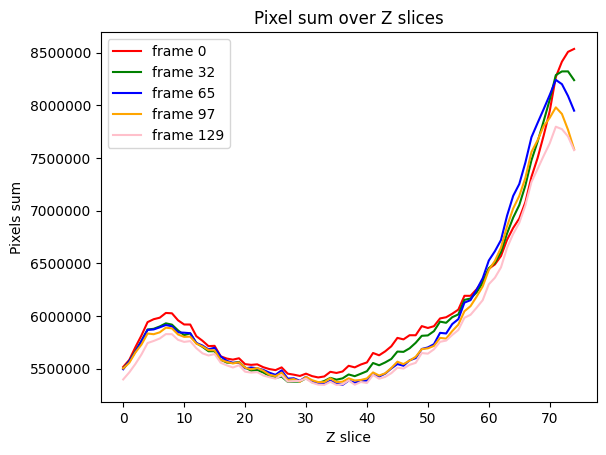

In [39]:
plot_z_sum('/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/Channel1_complete.tif')

Based on the above results the following boundaries can be determined
1. Basal (0-9)
2. Lateral(10-58)
3. Apical(59-75)

In [40]:
allocate_membrane_regions(df = final_tracks, basal_range = [0,10] , lateral_range = [10,58], apical_range = [58,75])

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive,membrane_region
24,24,8,0,7,268.426824,168.0,238.0,4,7,6,1.080068,1.625000,0.428571,False,False,Basal
36,36,34,0,33,299.000000,202.0,314.0,25,17,9,2.401203,2.500000,0.787879,True,True,Basal
62,62,21,0,20,319.333333,195.0,241.0,14,1,20,1.964246,3.476190,0.650000,False,False,Basal
73,73,8,0,7,345.835302,224.0,420.0,6,6,6,2.043674,6.625000,1.571429,True,True,Basal
91,91,21,0,20,300.333333,326.0,431.0,17,19,19,1.219383,8.619048,0.500000,True,True,Basal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18143,18143,7,123,129,226.485961,187.0,280.0,128,127,127,2.005698,34.857143,1.333333,True,True,Lateral
18165,18165,7,123,129,244.000000,164.0,270.0,128,129,127,0.735702,49.000000,0.000000,False,True,Lateral
18189,18189,7,123,129,256.953050,194.0,261.0,127,126,124,1.552199,63.857143,0.833333,False,False,Apical
18264,18264,6,124,129,235.560093,170.0,248.0,128,124,124,1.777270,46.666667,1.200000,False,False,Lateral


In [41]:
final_tracks.to_pickle('/Users/apple/Desktop/Akamatsu_Lab/Lap_track/Final/data/filtered_tracks.pkl')